In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../utils/")
# from res_processing_utils import get_ave_metric, running_mean
from res_processing_utils import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from plot_utils import save_csv, save_csv_only_y
from plot_utils import get_config_with_best_train_loss, get_config_with_best_test_acc
from plot_utils import plot_test_acc, plot_train_loss
from plot_utils import plot_best_config_multiple_epochs
from plot_utils import plot_best_config_fixed_epochs, plot_best_config_fixed_epochs

In [2]:
top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/logreg_hyper_sweep_2018_nov_17/"
pattern = "opt_sgd_momentum_0.0_lr_0.01_l2_reg_0.0005_"
train_loss = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="train_loss")
test_loss = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="test_loss")
test_acc = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="test_acc")
grad_norm = get_ave_metric(pattern, top_directory, seed_list=[1,2,3], metric="grad_norm")

In [3]:
train_loss.shape, test_loss.shape, test_acc.shape, grad_norm.shape

((60000,), (100,), (100,), (60000,))

In [4]:
train_loss[-1], test_loss[-1], test_acc[-1], grad_norm[-1]

(0.32927932268381116,
 0.3103491183593869,
 0.9214333333333333,
 0.3436193296670582)

## overall report



['_bc-svrg']
best test acc and config  0.9267666666666666 25 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.22991423705820505 99 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_lp-svrg']
best test acc and config  0.9238333333333334 3 opt_lp-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.242583396634743 99 opt_lp-svrg_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_svrg']
best test acc and config  0.9268 62 opt_svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.22986717605660195 99 opt_svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-sgd']
best test acc and config  0.9264333333333333 76 opt_bc-sgd_momentum_0.9_lr_0.01_l2_reg_1e-05_
best train loss and config  0.24570177186408046 99 opt_bc-sgd_momentum_0.0_lr_0.1_l2_reg_1e-05_


['_lp-sgd']
best test acc and config  0.9249 87 opt_lp-sgd_momentum_0.9_lr_0.01_l2_reg_1e-05_
best train loss and config  0.24636825636502901 99 opt_lp-sgd_momentum_0.0_lr_0.5_l2_reg_1e-05_


['_

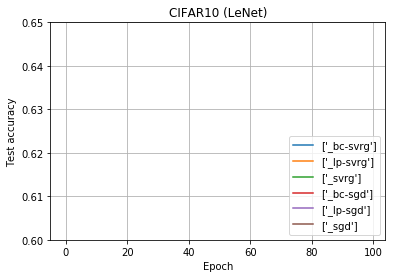

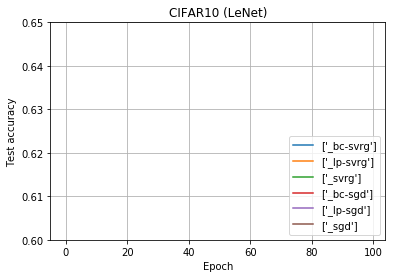

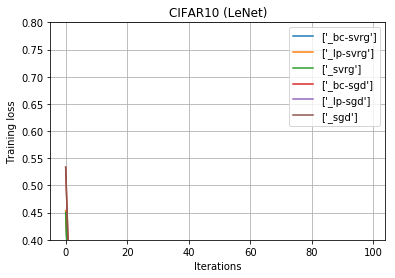

In [5]:
best_test_acc_list, best_train_loss_list, plot_label_list = \
    plot_best_config_fixed_epochs(cut_off_epoch=100, 
                                 total_epoch=100, 
                                 win_width=1000,
                                 top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/logreg_hyper_sweep_2018_nov_17/", 
                                 epoch_len=600)

In [6]:
save_list = ["halp", "svrg (16)", "svrg (32)", "sgd (16)", "sgd (32)"]

In [7]:
data_list = [(name, np.arange(y.size) + 1, np.maximum.accumulate(y)) \
             for name, y in zip(plot_label_list, best_test_acc_list) \
            if name in save_list ]
save_csv_only_y(data_list, 
         file_name="./data/logreg_test_acc_all.csv")
data_list = [(name, np.arange(y.size) + 1, y) \
             for name, y in zip(plot_label_list, best_train_loss_list) \
            if name in save_list ]
save_csv_only_y(data_list, 
         file_name="./data/logreg_train_loss_all.csv")

In [ ]:
# ckpt_epochs = np.arange(10, 101, 30)
ckpt_epochs = np.array([3, 5, 10, 15, 20, 30, 50, 100])
_, best_train_loss_list, best_test_acc_list = plot_best_config_multiple_epochs(ckpt_epochs, 
                                                                               total_epoch=100, 
                                                                               win_width=1000, 
                                                                               top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/logreg_hyper_sweep_2018_nov_17/",
                                                                               epoch_len=600)




['_bc-svrg'] 3
best test acc and config  0.9219333333333332 2 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.2748474555648631 2 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-svrg'] 5
best test acc and config  0.9242333333333334 3 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.261174484237904 4 opt_bc-svrg_momentum_0.9_lr_0.1_l2_reg_1e-05_


['_bc-svrg'] 10
best test acc and config  0.9255666666666666 9 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.2513977743123425 9 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-svrg'] 15
best test acc and config  0.9259666666666666 14 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.24588697593372927 14 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_


['_bc-svrg'] 20
best test acc and config  0.9262 18 opt_bc-svrg_momentum_0.9_lr_0.05_l2_reg_1e-05_
best train loss and config  0.24245524026305143 19 opt_bc-svrg_momen

In [ ]:
data_list = [(name, ckpt_epochs, np.maximum.accumulate(y)) \
             for name, y in zip(plot_label_list, best_test_acc_list)]
save_csv_only_y(data_list, 
         file_name="./data/logreg_test_acc_all_temporal.csv")
data_list = [(name, ckpt_epochs, y) \
             for name, y in zip(plot_label_list, best_train_loss_list)]
save_csv_only_y(data_list, 
         file_name="./data/logreg_train_loss_all.csv")